<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/G_g_p_p0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import csv
import math
import numpy as np
from astropy.coordinates import cartesian_to_spherical
import pandas as pd
import scipy as sp
from sklearn.neighbors import KDTree
from scipy import optimize
from google.colab import files
from collections import Counter
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# RMC Cooling Schedules

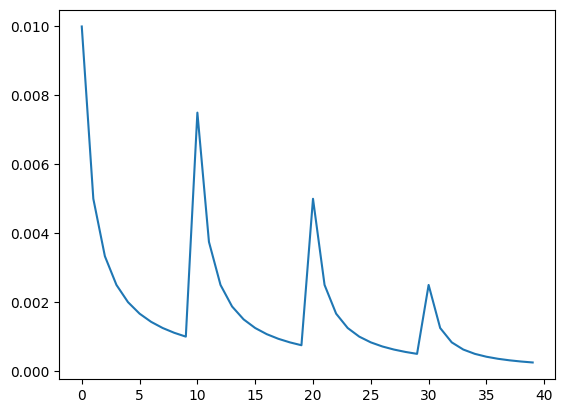

In [2]:
# CHecks whether the sigams in RMC code are acting as thought
loop1 = 4
loop2 = 10
beta = 1
sig_0 = 0.01
sigmas = []
for i in np.arange(1,loop1+1,1):
  sig_1 = sig_0*(loop1-i+1)/loop1
  for j in np.arange(1,loop2+1,1):
    sig_2 = sig_1/(j*beta)
    sigmas.append(sig_2)
plt.plot(sigmas)

# FCC Nearest Neighbors

In [3]:
###############################################################################
# Data taken from a r=75A Au FCC Sphere
###############################################################################
NN_distance = [np.sqrt(1/2), np.sqrt(2/2), np.sqrt(3/2), np.sqrt(4/2), np.sqrt(5/2), np.sqrt(6/2), np.sqrt(7/2), np.sqrt(8/2), np.sqrt(9/2), np.sqrt(10/2),
            np.sqrt(11/2), np.sqrt(12/2), np.sqrt(13/2), np.sqrt(14/2), np.sqrt(15/2), np.sqrt(16/2), np.sqrt(17/2), np.sqrt(18/2), np.sqrt(19/2), np.sqrt(20/2),
            np.sqrt(21/2), np.sqrt(22/2), np.sqrt(23/2), np.sqrt(24/2), np.sqrt(25/2), np.sqrt(26/2), np.sqrt(27/2)]
NN_count = [12, 6, 24, 12, 24, 8, 48, 6, 36, 24,
         24, 24, 72, 0, 48, 12, 48, 30, 72, 24,
         48, 24, 48, 8, 84, 24, 96]

# G(r) and all its Associates

In [4]:
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/STRs/Sphere100_Au_onAu_voidless.stru"
lp = 4.0789   # lattice paramter
N = 3925      # number of atoms

In [5]:
data = pd.read_csv(file, skiprows=3)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data["x"] = data["x"].astype(float)*lp
data["y"] = data["y"].astype(float)*lp
data["z"] = data["z"].astype(float)*lp
atom = data.atom
data = data.drop(data.columns[2], axis=1)
data

<ipython-input-5-c6a31c8fcca2>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


,y,z,x
0,-10.19725,-22.43395,-4.07890
1,-10.19725,-22.43395,0.00000
2,-10.19725,-22.43395,4.07890
3,-6.11835,-22.43395,-8.15780
4,-8.15780,-22.43395,-6.11835
...,...,...,...
3920,2.03945,24.47340,-2.03945
3921,0.00000,24.47340,0.00000
3922,2.03945,24.47340,2.03945
3923,0.00000,24.47340,4.07890


In [6]:
data_ar = data.to_numpy()
#tree = KDTree(data_ar, leaf_size=2)
#all_nn_indices = tree.query_radius(data_ar, r=np.sqrt(2)*1)

In [7]:
data_ar

array([[-10.19725, -22.43395,  -4.0789 ],
       [-10.19725, -22.43395,   0.     ],
       [-10.19725, -22.43395,   4.0789 ],
       ...,
       [  2.03945,  24.4734 ,   2.03945],
       [  0.     ,  24.4734 ,   4.0789 ],
       [  4.0789 ,  24.4734 ,   0.     ]])

## Calculating $\rho(r)$: number density of atoms

In [8]:
rho_0 = .05894 # for Au
const = 1/(4*np.pi*N)

In [9]:
# Calculates the distance from every atom to every other atom
distances = [np.linalg.norm(i-j) for i in data_ar for j in data_ar]

In [37]:
c = Counter(distances)
for key in c:
  c[key] = c[key]*const*1/(key*key)

<ipython-input-37-5b5467780906>:4: RuntimeWarning: divide by zero encountered in double_scalars
  c[key] = c[key]*const*1/(key*key)


<BarContainer object of 664 artists>

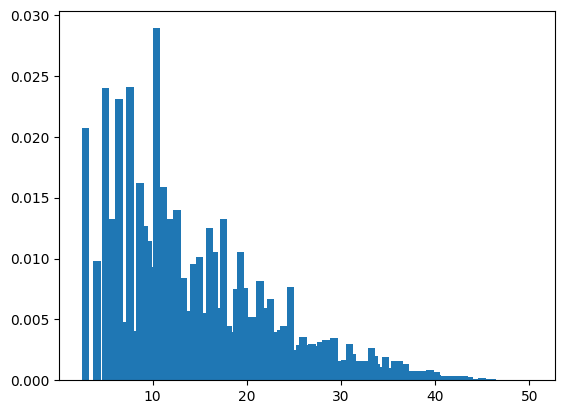

In [38]:
plt.bar(c.keys(), c.values())

In [39]:
g_r = c
for key in c:
  g_r[key] =g_r[key]/rho_0

<BarContainer object of 664 artists>

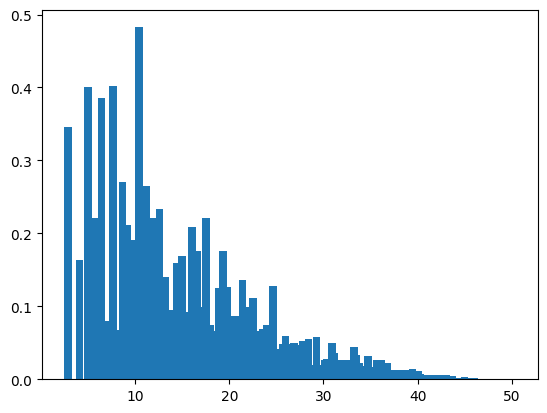

In [40]:
plt.bar(g_r.keys(), g_r.values())

In [41]:
G_r = c
for key in c:
  c[key] = 4*np.pi*key*(c[key]-rho_0)

<ipython-input-41-b06090fb5d4a>:3: RuntimeWarning: invalid value encountered in double_scalars
  c[key] = 4*np.pi*key*(c[key]-rho_0)


(0.0, 25.0)

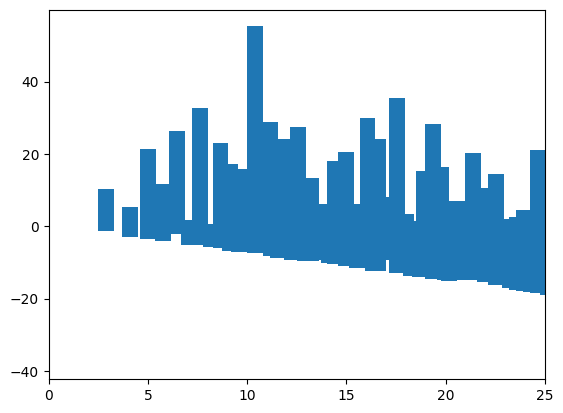

In [46]:
plt.bar(G_r.keys(), G_r.values())
plt.xlim(0,25)

In [10]:
r_min = 1
r_max = 25
bin_size = 1/10
half_bin=bin_size/2
r_range = np.arange(r_min,r_max+bin_size, bin_size)
rho_r = []
const = 1/(4*np.pi*N)
# Calculates rho_r
for r in r_range:
  rho_r.append(const*(1/(r*r))*[abs(r-d) <= half_bin for d in distances].count(True) )

In [11]:
print(rho_r)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1037978025820738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024922818492563347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06496927796676638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023541098620725336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037705846141546207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009980804707812421, 0.0, 0.0, 0.0, 0.0, 0.05121982747845099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005374977768685083, 0.0, 0.0, 0.0, 0.0, 0.028164138059709225, 0.0, 0.0, 0.0, 0.016864009131746967, 0.0, 0.0, 0.0, 0.0, 0.01487853734185776, 0.0, 0.0, 0.0, 0.013463899950123022, 0.0, 0.0, 0.0, 0.0368090418830669, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020481397850120386, 0.0, 0.0, 0.00478125954766236, 0.0, 0.0, 0.0, 0.01757916852699439, 0.0, 0.0, 0.010306166408191743, 0.0, 0.0, 0.0, 0.022803082679370847, 0.0, 0.0, 0.007172653384075973, 0.0, 0.0, 0.013482831767255699, 0.0, 0.0, 0.00635435006467916, 0.0, 0.0, 0.0119986291

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1037978025820738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024922818492563347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06496927796676638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023541098620725336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037705846141546207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009980804707812421, 0.0, 0.0, 0.0, 0.0, 0.05121982747845099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005374977768685083, 0.0, 0.0, 0.0, 0.0, 0.028164138059709225, 0.0, 0.0, 0.0, 0.016864009131746967, 0.0, 0.0, 0.0, 0.0, 0.01487853734185776, 0.0, 0.0, 0.0, 0.013463899950123022, 0.0, 0.0, 0.0, 0.0368090418830669, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020481397850120386, 0.0, 0.0, 0.00478125954766236, 0.0, 0.0, 0.0, 0.01757916852699439, 0.0, 0.0, 0.010306166408191743, 0.0, 0.0, 0.0, 0.022803082679370847, 0.0, 0.0, 0.007172653384075973, 0.0, 0.0, 0.013482831767255699, 0.0, 0.0, 0.00635435006467916, 0.0, 0.0, 0.0119986291

Text(0.5, 0, '$r(\\AA)$')

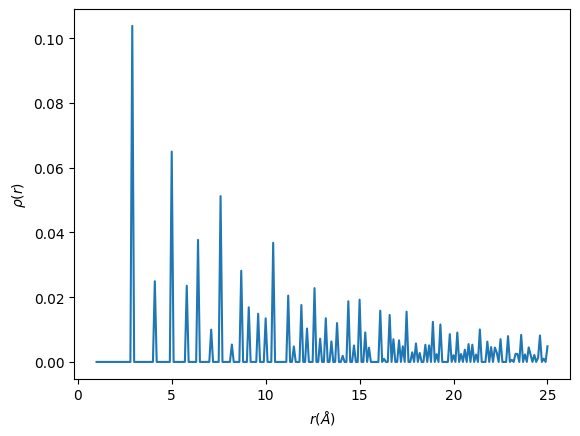

In [12]:
print(rho_r)
plt.plot(r_range,rho_r)
plt.ylabel(r'$\rho(r)$')
plt.xlabel(r'$r(\AA)$')

In [19]:
g_r = [x/rho_0 for x in rho_r]

Text(0.5, 0, '$r(\\AA)$')

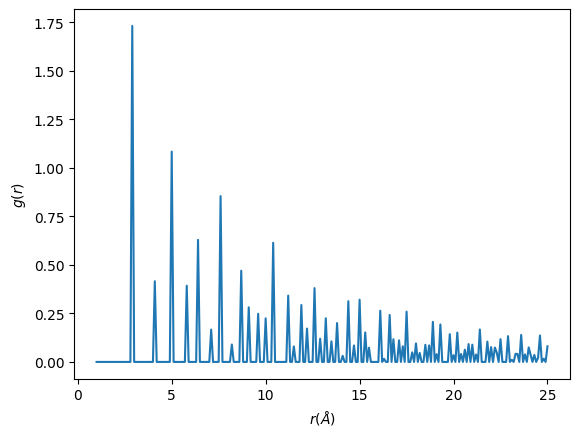

In [20]:
plt.plot(r_range,g_r)
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r(\AA)$')

In [21]:
G_r1 = [4*np.pi*r_range[x-1]*rho_0*(g_r[x-1]-1) for x in range(len(g_r))]
G_r2 = [4*np.pi*r_range[x-1]*(rho_r[x-1]-rho_0) for x in range(len(rho_r))]
G_r1 == G_r2

False

Text(0.5, 0, '$r(\\AA)$')

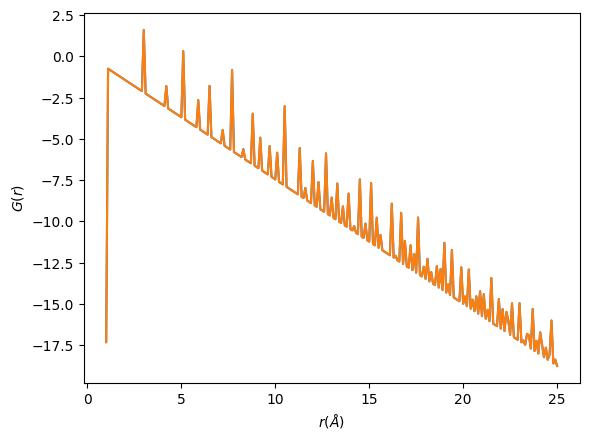

In [22]:
plt.plot(r_range,G_r1)
plt.plot(r_range,G_r2)
plt.ylabel(r'$G(r)$')
plt.xlabel(r'$r(\AA)$')

In [17]:
rho_0 = (3*N/(4*np.pi*r_max*r_max*r_max))
g_r = [x*rho_0 for x in rho_r]